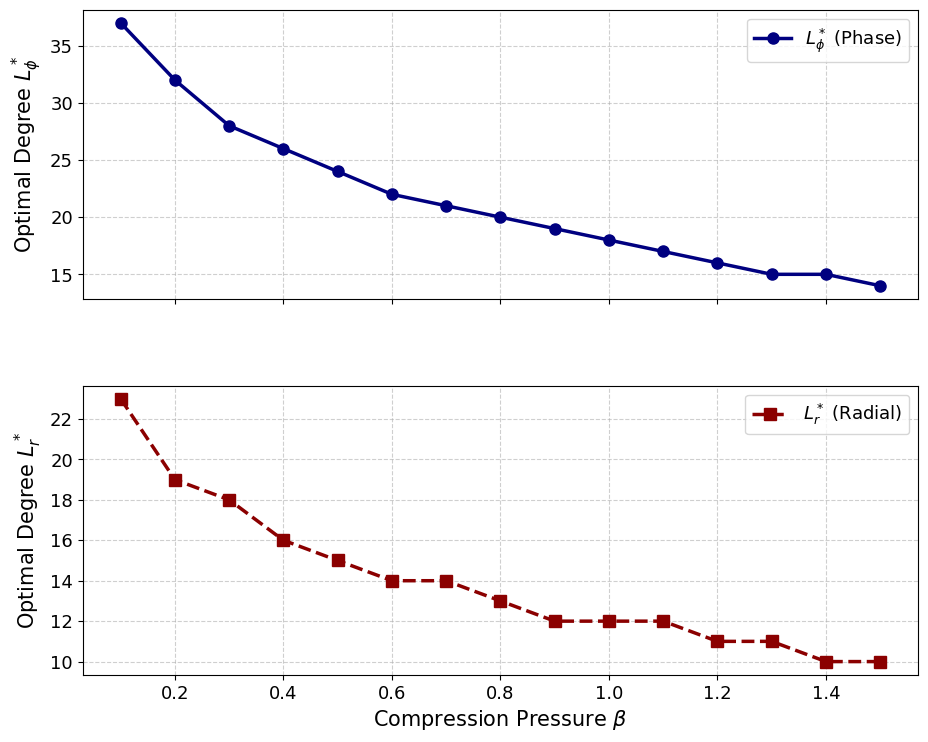

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# --- Load or define your performance and lmax arrays ---
lmax_array_phi = np.load("lmax_choice_final/phase_lmax_array.npy")
iou_array_phi = np.load("lmax_choice_final/phase_mean_iou.npy")
dims_array_phi = np.load('lmax_choice_final/phase_dims.npy')

lmax_array_rad = np.load("lmax_choice_final/radial_used_lmax_values.npy")
mae_array_rad = np.load("lmax_choice_final/radial_mae_per_lmax.npy")
dims_array_rad = np.load("lmax_choice_final/radial_dims_per_lmax.npy")


# --- Baselines ---
ae_mae = 0.5556
ae_iou = 0.363
ae_dim = 1152
ae_iou_baseline = ae_iou
ae_mae_baseline = ae_mae

# --- Params ---
k_lambda2_factor = 10.0
L_slope_cutoff_phi = 30
L_slope_cutoff_rad = 30
L_upper_threshold = 48
epsilon = 1e-9

def calculate_lambda1_from_precalc_dims(l_values, metric_values, precalc_dim_values,
                                        l_slope_cutoff, beta_val, w_val, is_mae=False):
    if len(l_values) < 2:
        return 1.0

    idx_start = 0
    valid_indices = np.where(l_values <= l_slope_cutoff)[0]

    if len(valid_indices) > 0:
        idx_cutoff = valid_indices[-1]
        if idx_cutoff == idx_start and len(l_values) > idx_start + 1:
            idx_cutoff = idx_start + 1
        elif idx_cutoff == idx_start:
            idx_cutoff = len(l_values) - 1
    else:
        idx_cutoff = len(l_values) - 1

    if idx_cutoff == idx_start:
        return 1.0

    delta_dims = precalc_dim_values[idx_cutoff] - precalc_dim_values[idx_start]
    if abs(delta_dims) < epsilon:
        return 1.0

    if is_mae:
        delta_metric = metric_values[idx_start] - metric_values[idx_cutoff]
    else:
        delta_metric = metric_values[idx_cutoff] - metric_values[idx_start]

    slope = abs(delta_metric / delta_dims)
    return beta_val * w_val * slope

def find_optimal_L_for_beta(beta_val,
                            lmax_phi_vals, iou_phi_vals, dims_phi_vals,
                            lmax_rad_vals, mae_rad_vals, dims_rad_vals,
                            ae_iou_b, ae_mae_b, k_l2_factor,
                            L_sc_phi, L_sc_rad, L_up_thresh, eps):
    w_phi = 1.0 / (1.0 - ae_iou_b + eps)
    w_r = 1.0 / (ae_mae_b + eps)

    lambda1_phi = calculate_lambda1_from_precalc_dims(
        lmax_phi_vals, iou_phi_vals, dims_phi_vals,
        L_sc_phi, beta_val, w_phi, is_mae=False
    )
    lambda1_r = calculate_lambda1_from_precalc_dims(
        lmax_rad_vals, mae_rad_vals, dims_rad_vals,
        L_sc_rad, beta_val, w_r, is_mae=True
    )

    lambda2_phi = k_l2_factor * lambda1_phi
    lambda2_r = k_l2_factor * lambda1_r

    D_thresh_phi = 3 * (12 * (L_up_thresh + 1)**2) / 2
    D_thresh_r = (12 * (L_up_thresh + 1)**2) / 2

    cost_phi = w_phi * (1 - iou_phi_vals) + lambda1_phi * dims_phi_vals + lambda2_phi * np.maximum(0, dims_phi_vals - D_thresh_phi)
    cost_r = w_r * mae_rad_vals + lambda1_r * dims_rad_vals + lambda2_r * np.maximum(0, dims_rad_vals - D_thresh_r)

    L_phi_star_val = lmax_phi_vals[np.argmin(cost_phi)]
    L_r_star_val = lmax_rad_vals[np.argmin(cost_r)]
    return L_phi_star_val, L_r_star_val

# --- Run for many beta values ---
beta_values = np.arange(0.1, 1.6, 0.1)
optimal_L_phi_list = []
optimal_L_r_list = []

for beta in beta_values:
    L_phi, L_r = find_optimal_L_for_beta(
        beta,
        lmax_array_phi, iou_array_phi, dims_array_phi,
        lmax_array_rad, mae_array_rad, dims_array_rad,
        ae_iou_baseline, ae_mae_baseline, k_lambda2_factor,
        L_slope_cutoff_phi, L_slope_cutoff_rad, L_upper_threshold, epsilon
    )
    optimal_L_phi_list.append(L_phi)
    optimal_L_r_list.append(L_r)

import matplotlib.pyplot as plt

# --- Improved Plotting for Publication ---

# Set global font sizes and style
plt.rcParams.update({
    "font.size": 14,           # Increase overall font size
    "axes.titlesize": 16,      # Title font
    "axes.labelsize": 15,      # Axis labels
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13,
    "figure.titlesize": 16,
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- L_phi* plot ---
axs[0].plot(beta_values, optimal_L_phi_list, marker='o', linestyle='-', color='navy', label='$L^*_{\\phi}$ (Phase)')
axs[0].set_ylabel('Optimal Degree $L^*_{\\phi}$')
#axs[0].set_title('Sensitivity of Optimal SH Degree $L^*$ to Compression Pressure $\\beta$')
axs[0].legend(loc='upper right')
axs[0].grid(True, linestyle='--', alpha=0.6)

# --- L_r* plot ---
axs[1].plot(beta_values, optimal_L_r_list, marker='s', linestyle='--', color='darkred', label='$L^*_{r}$ (Radial)')
axs[1].set_ylabel('Optimal Degree $L^*_{r}$')
axs[1].set_xlabel('Compression Pressure $\\beta$')
axs[1].legend(loc='upper right')
axs[1].grid(True, linestyle='--', alpha=0.6)

# Final layout adjustments
plt.tight_layout(pad=2.0)
plt.subplots_adjust(hspace=0.3)
fig.savefig("lmax_choice_final/beta-compression.png", dpi=300, bbox_inches="tight")
plt.show()



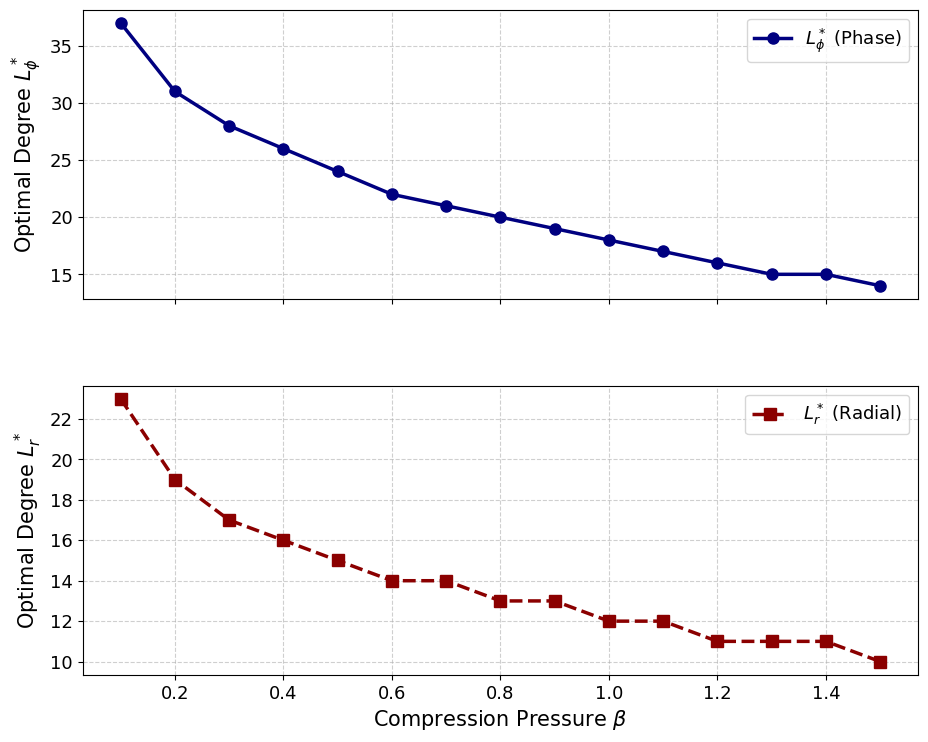

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- Load or define your performance and lmax arrays ---
lmax_array_phi = np.load("lmax_choice_final/phase_lmax_array.npy")
iou_array_phi = np.load("lmax_choice_final/phase_mean_iou.npy")
#dims_array_phi = np.load('lmax_choice_final/phase_dims.npy')

lmax_array_rad = np.load("lmax_choice_final/radial_used_lmax_values.npy")
mae_array_rad = np.load("lmax_choice_final/radial_mae_per_lmax.npy")
#dims_array_rad = np.load("lmax_choice_final/radial_dims_per_lmax.npy")

# Compute dimensions: sum_{l=0}^{lmax} (2l + 1) = (lmax + 1)^2
dims_array_phi = (lmax_array_phi + 1) ** 2
dims_array_rad = (lmax_array_rad + 1) ** 2

# --- Baselines ---
ae_mae = 0.5556
ae_iou = 0.363
ae_dim = 1152
ae_iou_baseline = ae_iou
ae_mae_baseline = ae_mae

# --- Params ---
k_lambda2_factor = 10.0
L_slope_cutoff_phi = 30
L_slope_cutoff_rad = 30
L_upper_threshold = 48
epsilon = 1e-9

def calculate_lambda1_from_precalc_dims(l_values, metric_values, precalc_dim_values,
                                        l_slope_cutoff, beta_val, w_val, is_mae=False):
    if len(l_values) < 2:
        return 1.0

    idx_start = 0
    valid_indices = np.where(l_values <= l_slope_cutoff)[0]

    if len(valid_indices) > 0:
        idx_cutoff = valid_indices[-1]
        if idx_cutoff == idx_start and len(l_values) > idx_start + 1:
            idx_cutoff = idx_start + 1
        elif idx_cutoff == idx_start:
            idx_cutoff = len(l_values) - 1
    else:
        idx_cutoff = len(l_values) - 1

    if idx_cutoff == idx_start:
        return 1.0

    delta_dims = precalc_dim_values[idx_cutoff] - precalc_dim_values[idx_start]
    if abs(delta_dims) < epsilon:
        return 1.0

    if is_mae:
        delta_metric = metric_values[idx_start] - metric_values[idx_cutoff]
    else:
        delta_metric = metric_values[idx_cutoff] - metric_values[idx_start]

    slope = abs(delta_metric / delta_dims)
    return beta_val * w_val * slope

def find_optimal_L_for_beta(beta_val,
                            lmax_phi_vals, iou_phi_vals, dims_phi_vals,
                            lmax_rad_vals, mae_rad_vals, dims_rad_vals,
                            ae_iou_b, ae_mae_b, k_l2_factor,
                            L_sc_phi, L_sc_rad, L_up_thresh, eps):
    w_phi = 1.0 / (1.0 - ae_iou_b + eps)
    w_r = 1.0 / (ae_mae_b + eps)

    lambda1_phi = calculate_lambda1_from_precalc_dims(
        lmax_phi_vals, iou_phi_vals, dims_phi_vals,
        L_sc_phi, beta_val, w_phi, is_mae=False
    )
    lambda1_r = calculate_lambda1_from_precalc_dims(
        lmax_rad_vals, mae_rad_vals, dims_rad_vals,
        L_sc_rad, beta_val, w_r, is_mae=True
    )

    lambda2_phi = k_l2_factor * lambda1_phi
    lambda2_r = k_l2_factor * lambda1_r

    D_thresh_phi = 3 * (12 * (L_up_thresh + 1)**2) / 2
    D_thresh_r = (12 * (L_up_thresh + 1)**2) / 2

    cost_phi = w_phi * (1 - iou_phi_vals) + lambda1_phi * dims_phi_vals + lambda2_phi * np.maximum(0, dims_phi_vals - D_thresh_phi)
    cost_r = w_r * mae_rad_vals + lambda1_r * dims_rad_vals + lambda2_r * np.maximum(0, dims_rad_vals - D_thresh_r)

    L_phi_star_val = lmax_phi_vals[np.argmin(cost_phi)]
    L_r_star_val = lmax_rad_vals[np.argmin(cost_r)]
    return L_phi_star_val, L_r_star_val

# --- Run for many beta values ---
beta_values = np.arange(0.1, 1.6, 0.1)
optimal_L_phi_list = []
optimal_L_r_list = []

for beta in beta_values:
    L_phi, L_r = find_optimal_L_for_beta(
        beta,
        lmax_array_phi, iou_array_phi, dims_array_phi,
        lmax_array_rad, mae_array_rad, dims_array_rad,
        ae_iou_baseline, ae_mae_baseline, k_lambda2_factor,
        L_slope_cutoff_phi, L_slope_cutoff_rad, L_upper_threshold, epsilon
    )
    optimal_L_phi_list.append(L_phi)
    optimal_L_r_list.append(L_r)

import matplotlib.pyplot as plt

# --- Improved Plotting for Publication ---

# Set global font sizes and style
plt.rcParams.update({
    "font.size": 14,           # Increase overall font size
    "axes.titlesize": 16,      # Title font
    "axes.labelsize": 15,      # Axis labels
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13,
    "figure.titlesize": 16,
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- L_phi* plot ---
axs[0].plot(beta_values, optimal_L_phi_list, marker='o', linestyle='-', color='navy', label='$L^*_{\\phi}$ (Phase)')
axs[0].set_ylabel('Optimal Degree $L^*_{\\phi}$')
#axs[0].set_title('Sensitivity of Optimal SH Degree $L^*$ to Compression Pressure $\\beta$')
axs[0].legend(loc='upper right')
axs[0].grid(True, linestyle='--', alpha=0.6)

# --- L_r* plot ---
axs[1].plot(beta_values, optimal_L_r_list, marker='s', linestyle='--', color='darkred', label='$L^*_{r}$ (Radial)')
axs[1].set_ylabel('Optimal Degree $L^*_{r}$')
axs[1].set_xlabel('Compression Pressure $\\beta$')
axs[1].legend(loc='upper right')
axs[1].grid(True, linestyle='--', alpha=0.6)

# Final layout adjustments
plt.tight_layout(pad=2.0)
plt.subplots_adjust(hspace=0.3)
fig.savefig("lmax_choice_final/beta-compression-final.png", dpi=300, bbox_inches="tight")
plt.show()



In [5]:
def find_beta_before_small_L_drop(L_vals, beta_vals, threshold=0.05):
    for i in range(1, len(L_vals)):
        prev_L = L_vals[i - 1]
        curr_L = L_vals[i]
        rel_drop = (prev_L - curr_L) / prev_L
        if rel_drop < threshold:
            return beta_vals[i - 1], rel_drop  # Return the last "significant" beta
    return beta_vals[-1], 0.0  # If drop never falls below threshold

# Find for phase and radial
beta_phi, drop_phi = find_beta_before_small_L_drop(optimal_L_phi_list, beta_values)
beta_rad, drop_rad = find_beta_before_small_L_drop(optimal_L_r_list, beta_values)

print(f"Chosen β for PHASE before <10% L drop: β = {beta_phi:.2f} (Relative drop = {drop_phi:.2%})")
print(f"Chosen β for RADIAL before <10% L drop: β = {beta_rad:.2f} (Relative drop = {drop_rad:.2%})")


Chosen β for PHASE before <10% L drop: β = 0.60 (Relative drop = 4.55%)
Chosen β for RADIAL before <10% L drop: β = 0.60 (Relative drop = 0.00%)


0.0003820203688451115
0.0009672144465568638
w_phi: 1.57e+00, w_r: 1.80e+00
Calculated λ1φ=3.60e-04, λ2φ=3.60e-03
Calculated λ1r=1.04e-03, λ2r=1.04e-02
Dimensionality threshold for λ2 (Phase): D_thresh_φ = 7203 (from L=48)
Dimensionality threshold for λ2 (Radial): D_thresh_r = 2401 (from L=48)

Optimal L_phase = 22 (SH_dim = 529)
Optimal L_rad   = 14 (SH_dim = 225)


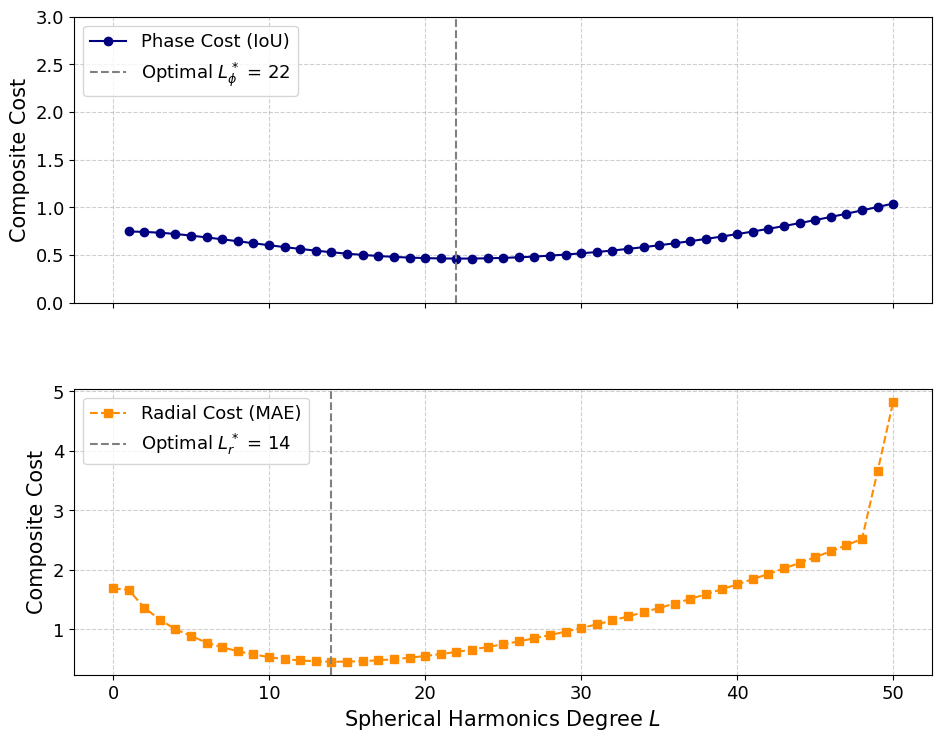

In [6]:
import numpy as np

ae_mae = 0.5556
ae_iou = 0.363

# Example baseline values (replace with your actual AE baseline results)
ae_iou_baseline = ae_iou
ae_mae_baseline = ae_mae



# Hyperparameters
beta = 0.6  # Compression pressure
k_lambda2_factor = 10.0  # Factor for λ2 relative to λ1

# L_slope_cutoff: L value up to which to calculate the initial "local" slope for λ1
L_slope_cutoff_phi = 30
L_slope_cutoff_rad = 30

# L_upper_threshold: L value beyond which the steeper λ2 penalty applies
L_upper_threshold = 48 # e.g., based on 3*Nside if Nside=16 (N_pix=3072 => Nside=16)

# --- 1. Normalization Weights ---
epsilon = 1e-9 # To prevent division by zero
w_phi = 1.0 / (1.0 - ae_iou_baseline + epsilon)
w_r = 1.0 / (ae_mae_baseline + epsilon)

# --- 2. Calculate λ1 (using local slope) ---
def calculate_lambda1_from_precalc_dims(
    l_values, metric_values, precalc_dim_values,
    l_slope_cutoff, beta_val, w_val, is_mae=False
):
    if len(l_values) < 2:
        print("Warning: Not enough data points. Defaulting lambda1.")
        return 1.0 # Default high penalty

    idx_start = 0
    potential_indices = np.where(l_values <= l_slope_cutoff)[0]

    if len(potential_indices) > 0 and potential_indices[-1] > idx_start:
        idx_cutoff = potential_indices[-1]
    elif len(l_values) > idx_start + 1: # Fallback: use next point if cutoff is too small
        idx_cutoff = idx_start + 1
        print(f"Warning: L_slope_cutoff ({l_slope_cutoff}) too small. Using L={l_values[idx_cutoff]}.")
    else: # Fallback: use global range if segment is invalid
        idx_cutoff = len(l_values) - 1
        print(f"Warning: L_slope_cutoff ({l_slope_cutoff}) invalid. Using global range L={l_values[idx_cutoff]}.")
        if idx_cutoff == idx_start: # Still not enough points
             print("Error: Not enough distinct points for slope calculation.")
             return 1.0

    metric_at_0 = metric_values[idx_start]
    metric_at_cutoff = metric_values[idx_cutoff]

    dims_at_0 = precalc_dim_values[idx_start]
    dims_at_cutoff = precalc_dim_values[idx_cutoff]

    delta_dims_local = dims_at_cutoff - dims_at_0
    if abs(delta_dims_local) < epsilon:
        print("Warning: Delta dimensions for local slope is near zero. Defaulting lambda1.")
        return 1.0

    if is_mae:
        delta_metric_local = metric_at_0 - metric_at_cutoff
    else:
        delta_metric_local = metric_at_cutoff - metric_at_0

    slope_local = abs(delta_metric_local / delta_dims_local)
    print(slope_local)
    return beta_val * w_val * slope_local

# For Phase (IoU)
lambda1_phi = calculate_lambda1_from_precalc_dims(
    lmax_array_phi, iou_array_phi, dims_array_phi,
    L_slope_cutoff_phi, beta, w_phi, is_mae=False
)
# For Radial (MAE)
lambda1_r = calculate_lambda1_from_precalc_dims(
    lmax_array_rad, mae_array_rad, dims_array_rad,
    L_slope_cutoff_rad, beta, w_r, is_mae=True
)

# --- 3. Calculate λ2 ---
lambda2_phi = k_lambda2_factor * lambda1_phi
lambda2_r = k_lambda2_factor * lambda1_r

# --- 4. Define D_threshold for λ2 activation (based on L_upper_threshold) ---
# Dimensionality at L_upper_threshold
D_thresh_val_phi = 3 * (L_upper_threshold + 1)**2
D_thresh_val_r = (L_upper_threshold + 1)**2

# --- 5. Calculate Composite Costs C(L) ---
# For Phase
error_term_phi = w_phi * (1.0 - iou_array_phi)
penalty_linear_phi = lambda1_phi * dims_array_phi # Use pre-calculated dims_array_phi
penalty_steep_phi = lambda2_phi * np.maximum(0, dims_array_phi - D_thresh_val_phi)
cost_phi = error_term_phi + penalty_linear_phi + penalty_steep_phi

# For Radial
error_term_r = w_r * mae_array_rad
penalty_linear_r = lambda1_r * dims_array_rad # Use pre-calculated dims_array_rad
penalty_steep_r = lambda2_r * np.maximum(0, dims_array_rad - D_thresh_val_r)
cost_r = error_term_r + penalty_linear_r + penalty_steep_r

# --- 6. Determine Optimal L* ---
# Ensure arrays are not empty before argmin
if cost_phi.size > 0:
    L_phi_star = lmax_array_phi[np.argmin(cost_phi)]
    dim_phi_star = dims_array_phi[np.argmin(cost_phi)]
else:
    L_phi_star, dim_phi_star = None, None

if cost_r.size > 0:
    L_r_star = lmax_array_rad[np.argmin(cost_r)]
    dim_r_star = dims_array_rad[np.argmin(cost_r)]
else:
    L_r_star, dim_r_star = None, None

# --- Output ---
print(f"w_phi: {w_phi:.2e}, w_r: {w_r:.2e}")
print(f"Calculated λ1φ={lambda1_phi:.2e}, λ2φ={lambda2_phi:.2e}")
print(f"Calculated λ1r={lambda1_r:.2e}, λ2r={lambda2_r:.2e}")
print(f"Dimensionality threshold for λ2 (Phase): D_thresh_φ = {D_thresh_val_phi} (from L={L_upper_threshold})")
print(f"Dimensionality threshold for λ2 (Radial): D_thresh_r = {D_thresh_val_r} (from L={L_upper_threshold})")
print(f"\nOptimal L_phase = {L_phi_star} (SH_dim = {dim_phi_star if dim_phi_star is not None else 'N/A'})")
print(f"Optimal L_rad   = {L_r_star} (SH_dim = {dim_r_star if dim_r_star is not None else 'N/A'})")


import matplotlib.pyplot as plt

# --- Matplotlib Style Setup for Publication ---
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 15,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13,
    "figure.titlesize": 16
})

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- Phase Cost Plot ---
axs[0].plot(
    lmax_array_phi, cost_phi,
    marker='o', linestyle='-', color='navy',
    label='Phase Cost (IoU)', linewidth=1.5, markersize=6
)
axs[0].axvline(
    x=L_phi_star, color='gray', linestyle='--', linewidth=1.5,
    label=f'Optimal $L^*_{{\\phi}}$ = {L_phi_star}'
)
axs[0].set_ylabel("Composite Cost")
#axs[0].set_title("Phase Representation")
axs[0].set_ylim(0, 3)
axs[0].legend(loc='upper left')
axs[0].grid(True, linestyle='--', alpha=0.6)

# --- Radial Cost Plot ---
axs[1].plot(
    lmax_array_rad, cost_r,
    marker='s', linestyle='--', color='darkorange',
    label='Radial Cost (MAE)', linewidth=1.5, markersize=6
)
axs[1].axvline(
    x=L_r_star, color='gray', linestyle='--', linewidth=1.5,
    label=f'Optimal $L^*_{{r}}$ = {L_r_star}'
)
axs[1].set_ylabel("Composite Cost")
axs[1].set_xlabel("Spherical Harmonics Degree $L$")
#axs[1].set_title("Radial Representation")
#axs[1].set_ylim(1, 4)
axs[1].legend(loc='upper left')
axs[1].grid(True, linestyle='--', alpha=0.6)

# --- Final Adjustments ---
plt.tight_layout(pad=2.0)
plt.subplots_adjust(hspace=0.3)
fig.savefig("lmax_choice_final/cost-function-final.png", dpi=300, bbox_inches="tight")

plt.show()


8.239655014306327e-05
0.001875809835746645
w_phi: 1.57e+00, w_r: 1.80e+00
Calculated λ1φ=7.76e-05, λ2φ=7.76e-04
Calculated λ1r=2.03e-03, λ2r=2.03e-02
Dimensionality threshold for λ2 (Phase): D_thresh_φ = 7203 (from L=48)
Dimensionality threshold for λ2 (Radial): D_thresh_r = 2401 (from L=48)

Optimal L_phase = 22 (SH_dim = 5589)
Optimal L_rad   = 14 (SH_dim = 120)


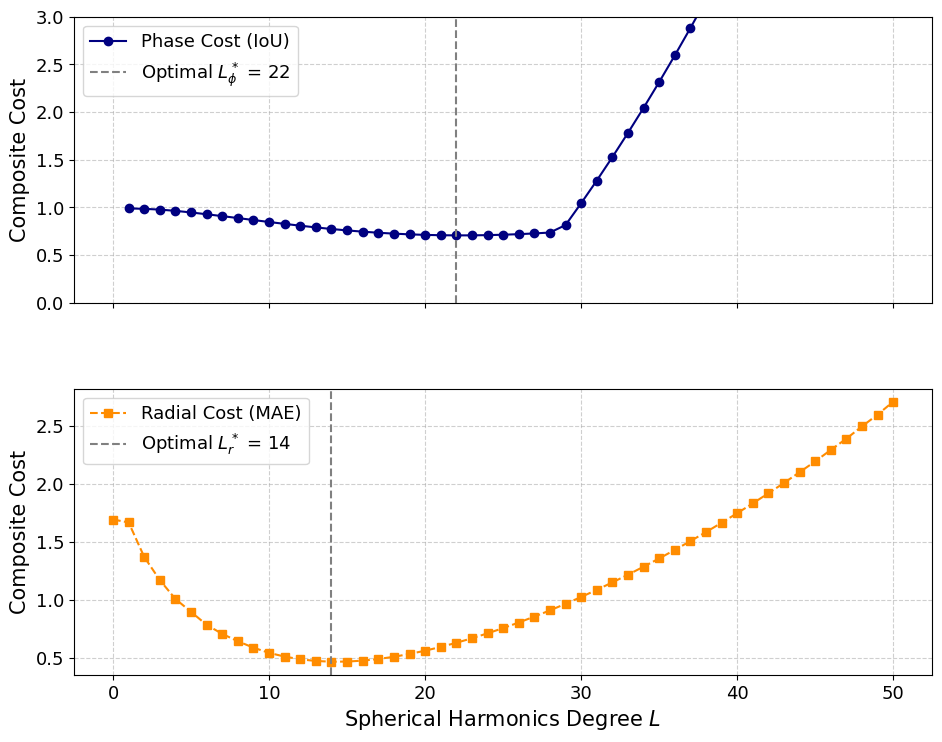

In [23]:
import numpy as np

ae_mae = 0.5556
ae_iou = 0.363

# Example baseline values (replace with your actual AE baseline results)
ae_iou_baseline = ae_iou
ae_mae_baseline = ae_mae



# Hyperparameters
beta = 0.6  # Compression pressure
k_lambda2_factor = 10.0  # Factor for λ2 relative to λ1

# L_slope_cutoff: L value up to which to calculate the initial "local" slope for λ1
L_slope_cutoff_phi = 30
L_slope_cutoff_rad = 30

# L_upper_threshold: L value beyond which the steeper λ2 penalty applies
L_upper_threshold = 48 # e.g., based on 3*Nside if Nside=16 (N_pix=3072 => Nside=16)

# --- 1. Normalization Weights ---
epsilon = 1e-9 # To prevent division by zero
w_phi = 1.0 / (1.0 - ae_iou_baseline + epsilon)
w_r = 1.0 / (ae_mae_baseline + epsilon)

# --- 2. Calculate λ1 (using local slope) ---
def calculate_lambda1_from_precalc_dims(
    l_values, metric_values, precalc_dim_values,
    l_slope_cutoff, beta_val, w_val, is_mae=False
):
    if len(l_values) < 2:
        print("Warning: Not enough data points. Defaulting lambda1.")
        return 1.0 # Default high penalty

    idx_start = 0
    potential_indices = np.where(l_values <= l_slope_cutoff)[0]

    if len(potential_indices) > 0 and potential_indices[-1] > idx_start:
        idx_cutoff = potential_indices[-1]
    elif len(l_values) > idx_start + 1: # Fallback: use next point if cutoff is too small
        idx_cutoff = idx_start + 1
        print(f"Warning: L_slope_cutoff ({l_slope_cutoff}) too small. Using L={l_values[idx_cutoff]}.")
    else: # Fallback: use global range if segment is invalid
        idx_cutoff = len(l_values) - 1
        print(f"Warning: L_slope_cutoff ({l_slope_cutoff}) invalid. Using global range L={l_values[idx_cutoff]}.")
        if idx_cutoff == idx_start: # Still not enough points
             print("Error: Not enough distinct points for slope calculation.")
             return 1.0

    metric_at_0 = metric_values[idx_start]
    metric_at_cutoff = metric_values[idx_cutoff]

    dims_at_0 = precalc_dim_values[idx_start]
    dims_at_cutoff = precalc_dim_values[idx_cutoff]

    delta_dims_local = dims_at_cutoff - dims_at_0
    if abs(delta_dims_local) < epsilon:
        print("Warning: Delta dimensions for local slope is near zero. Defaulting lambda1.")
        return 1.0

    if is_mae:
        delta_metric_local = metric_at_0 - metric_at_cutoff
    else:
        delta_metric_local = metric_at_cutoff - metric_at_0

    slope_local = abs(delta_metric_local / delta_dims_local)
    print(slope_local)
    return beta_val * w_val * slope_local

# For Phase (IoU)
lambda1_phi = calculate_lambda1_from_precalc_dims(
    lmax_array_phi, iou_array_phi, dims_array_phi,
    L_slope_cutoff_phi, beta, w_phi, is_mae=False
)
# For Radial (MAE)
lambda1_r = calculate_lambda1_from_precalc_dims(
    lmax_array_rad, mae_array_rad, dims_array_rad,
    L_slope_cutoff_rad, beta, w_r, is_mae=True
)

# --- 3. Calculate λ2 ---
lambda2_phi = k_lambda2_factor * lambda1_phi
lambda2_r = k_lambda2_factor * lambda1_r

# --- 4. Define D_threshold for λ2 activation (based on L_upper_threshold) ---
# Dimensionality at L_upper_threshold
D_thresh_val_phi = 3 * (L_upper_threshold + 1)**2
D_thresh_val_r = (L_upper_threshold + 1)**2

# --- 5. Calculate Composite Costs C(L) ---
# For Phase
error_term_phi = w_phi * (1.0 - iou_array_phi)
penalty_linear_phi = lambda1_phi * dims_array_phi # Use pre-calculated dims_array_phi
penalty_steep_phi = lambda2_phi * np.maximum(0, dims_array_phi - D_thresh_val_phi)
cost_phi = error_term_phi + penalty_linear_phi + penalty_steep_phi

# For Radial
error_term_r = w_r * mae_array_rad
penalty_linear_r = lambda1_r * dims_array_rad # Use pre-calculated dims_array_rad
penalty_steep_r = lambda2_r * np.maximum(0, dims_array_rad - D_thresh_val_r)
cost_r = error_term_r + penalty_linear_r + penalty_steep_r

# --- 6. Determine Optimal L* ---
# Ensure arrays are not empty before argmin
if cost_phi.size > 0:
    L_phi_star = lmax_array_phi[np.argmin(cost_phi)]
    dim_phi_star = dims_array_phi[np.argmin(cost_phi)]
else:
    L_phi_star, dim_phi_star = None, None

if cost_r.size > 0:
    L_r_star = lmax_array_rad[np.argmin(cost_r)]
    dim_r_star = dims_array_rad[np.argmin(cost_r)]
else:
    L_r_star, dim_r_star = None, None

# --- Output ---
print(f"w_phi: {w_phi:.2e}, w_r: {w_r:.2e}")
print(f"Calculated λ1φ={lambda1_phi:.2e}, λ2φ={lambda2_phi:.2e}")
print(f"Calculated λ1r={lambda1_r:.2e}, λ2r={lambda2_r:.2e}")
print(f"Dimensionality threshold for λ2 (Phase): D_thresh_φ = {D_thresh_val_phi} (from L={L_upper_threshold})")
print(f"Dimensionality threshold for λ2 (Radial): D_thresh_r = {D_thresh_val_r} (from L={L_upper_threshold})")
print(f"\nOptimal L_phase = {L_phi_star} (SH_dim = {dim_phi_star if dim_phi_star is not None else 'N/A'})")
print(f"Optimal L_rad   = {L_r_star} (SH_dim = {dim_r_star if dim_r_star is not None else 'N/A'})")


import matplotlib.pyplot as plt

# --- Matplotlib Style Setup for Publication ---
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 15,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13,
    "figure.titlesize": 16
})

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- Phase Cost Plot ---
axs[0].plot(
    lmax_array_phi, cost_phi,
    marker='o', linestyle='-', color='navy',
    label='Phase Cost (IoU)', linewidth=1.5, markersize=6
)
axs[0].axvline(
    x=L_phi_star, color='gray', linestyle='--', linewidth=1.5,
    label=f'Optimal $L^*_{{\\phi}}$ = {L_phi_star}'
)
axs[0].set_ylabel("Composite Cost")
#axs[0].set_title("Phase Representation")
axs[0].set_ylim(0, 3)
axs[0].legend(loc='upper left')
axs[0].grid(True, linestyle='--', alpha=0.6)

# --- Radial Cost Plot ---
axs[1].plot(
    lmax_array_rad, cost_r,
    marker='s', linestyle='--', color='darkorange',
    label='Radial Cost (MAE)', linewidth=1.5, markersize=6
)
axs[1].axvline(
    x=L_r_star, color='gray', linestyle='--', linewidth=1.5,
    label=f'Optimal $L^*_{{r}}$ = {L_r_star}'
)
axs[1].set_ylabel("Composite Cost")
axs[1].set_xlabel("Spherical Harmonics Degree $L$")
#axs[1].set_title("Radial Representation")
#axs[1].set_ylim(1, 4)
axs[1].legend(loc='upper left')
axs[1].grid(True, linestyle='--', alpha=0.6)

# --- Final Adjustments ---
plt.tight_layout(pad=2.0)
plt.subplots_adjust(hspace=0.3)
fig.savefig("lmax_choice_final/cost-function.png", dpi=300, bbox_inches="tight")

plt.show()
